In [6]:
# INFO: execute shell commands directly by prefixing them with '!'
!pip install numpy scipy matplotlib seaborn sympy scipy autograd pandas symengine

In [7]:
import numpy as np
import scipy.integrate
import scipy.optimize

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

import sympy
import scipy
from scipy.optimize import fsolve

import autograd.numpy as np
from autograd import grad, jacobian

import pandas as pd

import symengine



In [8]:
sns.set(style='whitegrid')

## Set parameter and initial conditions

In [9]:
# Parameters
gamma = 2
beta = 5
n = 2
args = (beta, gamma, n)

aStimulusRange = [0, 6]
bStimulusRange = [0, 6]

# Initial condition
ab0 = np.array([1, 1.1])
print(ab0)

# Solve

t = np.linspace(0, 30, 200)

[1.  1.1]


For the lorenz system

## Design the ODE model

In [10]:
# solve this ODE System
def solveODESystem(ab, t, beta, gamma, n):

    a, b = ab

    dadt = beta / (1 + b**n) - a
    dbdt = gamma * (beta / (1 + a**n) - b)

    return np.array([dadt,dbdt])

## Calculate the fixed points 

In [11]:
def calculateFixPoints(ab, beta, gamma,n):
    a,b = ab

    dadt = beta / (1 + b**n) - a
    dbdt = gamma * (beta / (1 + a**n) - b)

    return np.array([dadt,dbdt])

## How to solve the separatrix

In [12]:
# For computing the separatrix, we start at the saddle and then integrate the 
# system backwards in time, starting just off of the saddle point.
def newSeparatrix(fixedPoints, aStimulusRange, bStimulusRange, beta, gamma, n, t_max=50, eps=5e-6, 
                           color='tomato', lw=3):

    # Negative time function to integrate to compute separatrix
    def rhs(ab, t):
        # Unpack variables
        a, b = ab
    
        # Stop integrating if we get the edge of where we want to integrate
        if aStimulusRange[0] < a < aStimulusRange[1] and bStimulusRange[0] < b < bStimulusRange[1]:
            return -solveODESystem(ab, t, beta, gamma, n)
        else:
            return np.array([0, 0]) 

    # Parameters for building separatrix
    t = np.linspace(0, t_max, 400)
    
    # Build upper right branch of separatrix
    ab0 = fixedPoints + eps
    ab_upper = scipy.integrate.odeint(rhs, ab0, t)

    # Build lower left branch of separatrix
    ab0 = fixedPoints - eps
    ab_lower = scipy.integrate.odeint(rhs, ab0, t)

    # Concatenate, reversing lower so points are sequential
    sep_a = np.concatenate((ab_lower[::-1,0], ab_upper[:,0]))
    sep_b = np.concatenate((ab_lower[::-1,1], ab_upper[:,1]))
    
    # create the separatrix time series as a pandas dataframe
    createDataFrameDict = {'a': list(sep_a), 'b': list(sep_b)}
    pdDataFrame = pd.DataFrame(data=createDataFrameDict)
        
    return pdDataFrame

solve the equation system for 
$$
f(x)=0
$$

In [13]:
# calculate the fixpoints

# NOTE: google for scipy.optimize.root 

# start at x0 (your inititial guess of location of the fixed point) type = ndarray
# NOTE: root and fsolve calculate the same. i can not approve which one is the most
# time efficient
# sol = scipy.optimize.root(testCalculateFixPoints, x0=[4, 0], args=(beta, gamma, n),method='hybr')
# print(sol.x)

fixedPoints = (fsolve(calculateFixPoints, x0=ab0, args=(beta, gamma, n)),)


## Calculate the Jacobian


Using the SymEngine module:

In [14]:
variables = symengine.symbols('a b') # Define x and y variables

# Define the function
f = symengine.sympify(['beta / (1 + b**n) - a', 'gamma * (beta / (1 + a**n) - b)']) 

# initialize Jacobian matrix
J = symengine.zeros(len(f),len(variables)) 

# Fill Jacobian matrix with entries
for i, fi in enumerate(f):
    for j, s in enumerate(variables):
        J[i,j] = symengine.diff(fi, s)

# convert J to a sympy matrix
stringJ = sympy.Matrix(J)

## Evalulate Jacobian 
Now evaluate the Jacobian Matrix with the found fixed points coordinates

In [15]:
# TODO: generalize this approach 

fixedPointsDict = {}
numFixPoints = 0

for i in fixedPoints:

  placeHolderDict = {}
  placeHolderDict['a'] = i[0]
  placeHolderDict['b'] = i[1]
  fixedPointsDict[numFixPoints] = placeHolderDict
  numFixPoints += 1
  
# eval the J matrix
parameterDict = dict()
parameterDict['gamma'] = 2
parameterDict['beta'] = 5
parameterDict['n'] = 2


## Calculate the eigenvalues
calculate the eigenvalues with the jacobi matrix $\mathbf{J}$
$$\mathbf{J}=\begin{pmatrix} 2*x*y & x^2 \\ 5 & cos(y) \end{pmatrix}$$

control whether all eigenvalues are positiv.

*Background knowledge*: the stationary solution is unstable if the real part of one eigenvalue is positiv.

In [16]:
def controlEigenvalues(eigenvalues):
  for i in eigenvalues:
    if i > 0:
      return 'unstable'
  return 'stable' 

In [17]:
unstableFixedPoints = []

for i,j in fixedPointsDict.items():
  # merge the parameter dict with the fixed point solution
  mergedDict = dict(**parameterDict, **j)

  numberJ = np.array(np.array(stringJ.subs(mergedDict)),dtype=float)
  
  # calculate the eigenvalues
  eigenvalues = np.linalg.eigvals(numberJ)
 
  # check whether the fixed point is stable or unstable 
  if controlEigenvalues(eigenvalues) == 'unstable':
    unstableFixedPoints.append(j)

# NOTE: Temporary solution
unstableFixedPointsTuple = ()
for i in unstableFixedPoints:
    unstableFixedPointsTuple += (np.array(list(i.values())),)
print(unstableFixedPointsTuple)

(array([1.51598023, 1.51598023]),)


## Plot the separatrix space

The results of the simulations are time series of each 1 separatrix.

There exists *2n* separatrices for *n* saddle points.

The task **remains** to visualize them in one plot / visualizations.

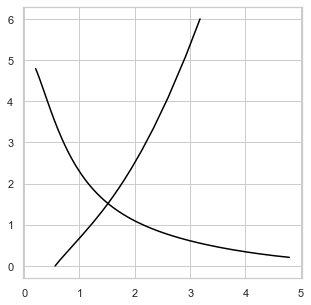

In [18]:
# We can generate lots and lots of trajectories to see how the system evolves.
# We can do this by solving for the dynamics for different initial conditions.

tmax = 50
plt.figure(figsize=(5,5))

timeSeriesList = []
pdDataFrame = newSeparatrix(unstableFixedPointsTuple[0], aStimulusRange, bStimulusRange, beta, gamma, n, t_max=tmax)
pdDataFrame2 = newSeparatrix(unstableFixedPointsTuple[0], aStimulusRange, bStimulusRange, beta, gamma, n, t_max=-tmax)

timeSeriesList.append(pdDataFrame)
timeSeriesList.append(pdDataFrame2)

for i in timeSeriesList:
  
  # split the array column-wise
  splittedList = np.hsplit(i.values,2)
  plt.plot(splittedList[0],splittedList[1], color='black')

plt.show()
